# EDX Quantification using Partial Ionization Cross Section

This is a personal workbook used to process my own data but has been made public for the use of others. If you find any errors or need further help using this workbook please contact k8macarthur@gmail.com.

## Author

Katherine E. MacArthur - Originally written for EMC2016, 28.08.2016

## Requirements

In order to use the EDX Cross Section quantification a Hyperspy version 1.1 or later is required.

## 1. Importing Hyperspy and Libraries

Being by importing the Hyperspy Function Library.

In [1]:
import matplotlib
matplotlib.rcParams["backend"] = 'nbagg'
import hyperspy.api as hs
import numpy as np

## 2. Importing and Calibrating the Experimental Data

Opens a load window. Use hs.load('filename') if filename is known specifically.

In [20]:
from urllib.request import urlretrieve, urlopen
from zipfile import ZipFile
files = urlretrieve("https://www.dropbox.com/s/u6pxsnselx5xvry/PtNiOctahedron.bcf?dl=0", "PtNiOctahedron.bcf")

In [21]:
s = hs.load('PtNiOctahedron.bcf')
s

TypeError: file 'PtNiOctahedron.bcf' is not SFS container

These next two lines are needed for .bcf files from Bruker/Espirit as the imported data comes as a list containing both the ADF image and EDX spectral data cube.

In [5]:
image = s[0]
s = s[1]
s

<EDSTEMSpectrum, title: EDX, dimensions: (300, 300|2048)>

In [6]:
s.set_signal_type('EDS_TEM')
s.metadata.General.title = 'Original Data Cube'
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 45.0
│       │       ├── detector_type = SuperX
│       │       ├── elevation_angle = 18.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       └── real_time = 950.496
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── beam_energy = 200
│       └── magnification = 1300000
├── General
│   ├── date = 2016-12-09
│   ├── original_filename = PtNiOctahedron.bcf
│   ├── time = 19:14:12
│   └── title = Original Data Cube
├── Sample
│   ├── elements = ['C', 'F', 'Ni', 'O', 'Pt']
│   ├── name = PG_3
│   └── xray_lines = ['C_Ka', 'F_Ka', 'Ni_Ka', 'O_Ka', 'Pt_La']
└── Signal
    ├── binned = True
    ├── quantity = X-rays (Counts)
    └── signal_type = EDS_TEM

Adjust the metadata for all the microscope parameters.

In [9]:
s.set_microscope_parameters()
#beam_energy = 200
#live_time = 1
#real_time = 0.003024 s
#beam_current = 0.0432 nA

In [10]:
s.axes_manager[0].name = 'x'
s.axes_manager[1].name = 'y'
s.axes_manager

<Axes manager, axes: (300, 300|2048)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    300 |      0 |       0 | 6.9e-05 |     µm 
               y |    300 |      0 |       0 | 6.9e-05 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   2048 |        |   -0.47 |    0.01 |    keV

Opens three windows to edit the scale and offset of each axis including the EDX Energy axis.

In [11]:
s.axes_manager.gui()
#The .bcf file currently imports with a pixel width measured in um.
#Correct to nm in order to get a more realistic scale bar.

Again the following line  is needed for bcf to chech the ADF image details.

In [12]:
image.axes_manager.gui()

Plotting both the image and the spectrum to see that they are imported correctly.

In [13]:
#This first line removes the first 50 energy channels from the spectrum image.
#Again this an addition needed specfically to clean up .bcf files.
s = s.isig[50:]
s.plot()
image.plot()

Setting the elements to be used for quantification. Make sure that these match those used for calibration samples.

In [14]:
s.set_elements(['Pt','Ni'])
s.set_lines(['Pt_La', 'Ni_Ka'])
s.metadata.Sample

├── elements = ['Ni', 'Pt']
├── name = PG_3
└── xray_lines = ['Ni_Ka', 'Pt_La']

## 3. Importing the Cross Sections Library and Checking Backround and Integration Windows

Import the calibration files of EDX cross sections for the correct microscope.

More details on how to make these files are inluded in the workbook entitled: 'Wedge Analysis - EDX Cross Sections .ipynb'.

In [16]:
cal = hs.load('EDX-data/ChemiSTEMCal_16AUG17.hspy')
calibration = cal.metadata.calibration

Check which elements are included within the calbration file.

In [21]:
calibration.keys()

['Co', 'Ni', 'Pd', 'Pt']

Extract the calibration information for each element, required for quantification.

In [22]:
cal_Ni = calibration['Ni']
cal_Pt = calibration['Pt']
cal_Ni

├── Background windows = array([[ 6.61175942,  6.75614952,  7.76688019,  7.86688019]])
├── Integration windows = [[7.189319806773387, 7.766880193226614]]
├── cross_section = 11.057032106497036
└── lines = ['Ni_Ka']

The following section converts the imported calibration dictionaries into a combinations of integration windows, background windows and cross section lists in a format which the intensity extraction function can use.

In [24]:
iw = cal_Ni['Integration windows'] + cal_Pt['Integration windows']
iw

[[7.189319806773387, 7.766880193226614],
 [9.201358177708983, 9.682841822291017]]

In [27]:
bw = np.append(cal_Ni['Background windows'], 
               cal_Pt['Background windows'],
              axis=0)
bw

array([[  6.61175942,   6.75614952,   7.76688019,   7.86688019],
       [  8.47913271,   8.63962726,  10.2       ,  10.3       ]])

In [28]:
cs = cal_Ni['cross_section'],cal_Pt['cross_section']
cs

(11.057032106497036, 12.823935650563929)

Check that the background windows and integration windows still work on the experimental data. As the calibration samples are single element, they may have selected windows which overlap with other elemental peaks which are in the final experimental data. 

*If you do need to change bw and iw here, it is advised to repeat the wedge calibration workbook so that both sets of integration windows match completely. Background windows are less critical but integration windows should be kept the same between calibration and experiment.*

In [29]:
bw = s.estimate_background_windows(line_width=[5.0, 2.0])
iw =  s.estimate_integration_windows(windows_width=4)
print(bw)
print(iw)

[[ 6.61175942  6.75614952  7.76688019  7.91127029]
 [ 8.47913271  8.63962726  9.7630891   9.92358364]]
[[7.189319806773387, 7.766880193226614], [9.121110903611976, 9.763089096388024]]


In [30]:
s.sum().plot(True, background_windows=bw, integration_windows=iw)

## 4. Quantifying the Experimental Data, using s.quantification()

If the spectrum requires binnning, it is better to do this now before extracting the intensities.

I normally use the non-integer binning method with linearly interpolates between pixels, and allows conversion of pixel size to any size in the range. The most realistic approach is to fit the pixel size such that one pixel is ~1 atomic column.

Begin by setting the scale function for each dimension in the spectrum data. A bin scale of 1 is required for any dimensions where no binning is wanted. 

In [31]:
scale = [9.583, 9.583, 1]

In [32]:
s = s.rebin(scale=scale)

In [33]:
s.plot()

In [34]:
s.change_dtype('float')
inten = s.get_lines_intensity(background_windows=bw, integration_windows=iw)

In [35]:
p = s.quantification(inten, 'cross_section', cs)

c:\users\macark\documents\github\hyperspy\hyperspy\misc\eds\utils.py:528: RuntimeWarning: invalid value encountered in true_divide
  composition = number_of_atoms / total_atoms


In [36]:
p

([<BaseSignal, title: atomic percent of Ni, dimensions: (31, 31|)>,
  <BaseSignal, title: atomic percent of Pt, dimensions: (31, 31|)>],
 [<BaseSignal, title: atom counts of Ni, dimensions: (31, 31|)>,
  <BaseSignal, title: atom counts of Pt, dimensions: (31, 31|)>])

Subsequent processing and image plotting and of the resulting data.

NB: Anything below this point is still work in progress.

Plotting the atomic percents of Ni and Pt

In [37]:
p[0][0].plot()
p[0][1].plot()

In [41]:
Total = p[1][0] + p[1][1]

<IPython.core.display.Javascript object>


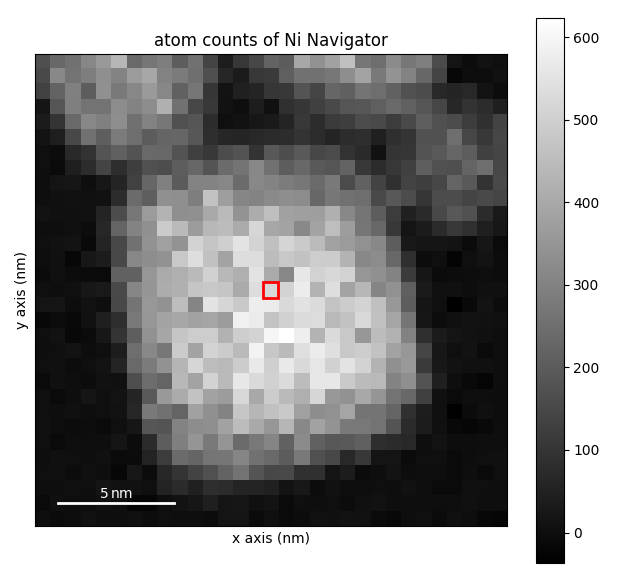

In [42]:
Total.plot()

<IPython.core.display.Javascript object>


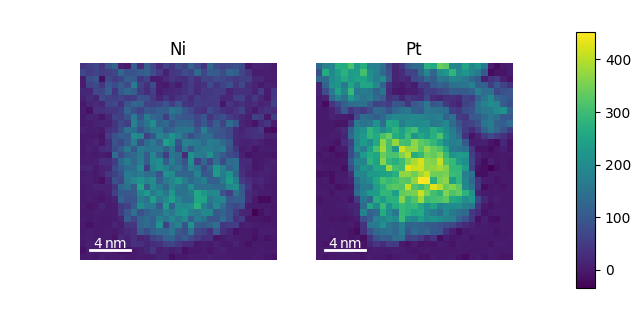

In [47]:
NumNi = p[1][0].as_signal2D((0,1))
NumPt = p[1][1].as_signal2D((0,1))
hs.plot.plot_images([NumNi, NumPt], scalebar ='all', cmap='viridis', colorbar ='single',
                   label=['Ni', 'Pt'], axes_decor='off', vmin=0)

<IPython.core.display.Javascript object>


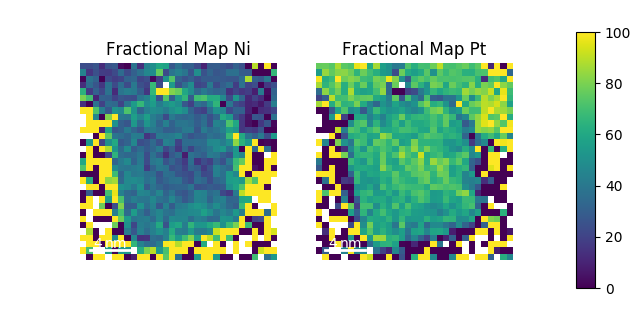

In [65]:
FractNi = p[0][0].as_signal2D((0,1))
FractPt = p[0][1].as_signal2D((0,1))
hs.plot.plot_images([FractNi, FractPt], scalebar ='all', cmap='viridis', colorbar ='single',
                    centre_colormap=False,
                    label=['Fractional Map Ni', 'Fractional Map Pt'], 
                    axes_decor='off', saturated_pixels=10)